In [8]:
import os
# 用 os.chdir() 跳到 main
os.chdir('/home/bonzo_yang/github/openai/street-fighter-ai/main')

In [9]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

Victory!
Total reward: 0.5830340794219446

Winning rate: 1.0
Average reward for ppo_ryu_2500000_steps_updated: 0.5260311267177284


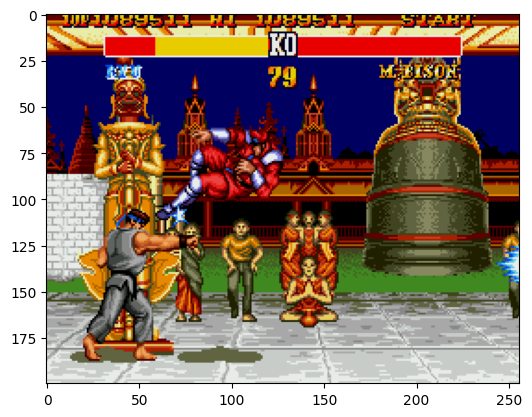

In [10]:
# Copyright 2023 LIN Yi. All Rights Reserved.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

import os
import time 

import retro
from stable_baselines3 import PPO

from street_fighter_custom_wrapper import StreetFighterCustomWrapper

RESET_ROUND = True  # Whether to reset the round when fight is over. 
RENDERING = True    # Whether to render the game screen.

MODEL_NAME = r"ppo_ryu_2500000_steps_updated" # Speicify the model file to load. Model "ppo_ryu_2500000_steps_updated" is capable of beating the final stage (Bison) of the game.

# Model notes:
# ppo_ryu_2000000_steps_updated: Just beginning to overfit state, generalizable but not quite capable.
# ppo_ryu_2500000_steps_updated: Approaching the final overfitted state, cannot dominate first round but partially generalizable. High chance of beating the final stage.
# ppo_ryu_3000000_steps_updated: Near the final overfitted state, almost dominate first round but barely generalizable.
# ppo_ryu_7000000_steps_updated: Overfitted, dominates first round but not generalizable. 

RANDOM_ACTION = False
NUM_EPISODES = 3#30 # Make sure NUM_EPISODES >= 3 if you set RESET_ROUND to False to see the whole final stage game.
MODEL_DIR = r"trained_models/"

def make_env(game, state):
    def _init():
        env = retro.make(
            game=game, 
            state=state, 
            use_restricted_actions=retro.Actions.FILTERED,
            obs_type=retro.Observations.IMAGE
        )
        env = StreetFighterCustomWrapper(env, reset_round=RESET_ROUND, rendering=RENDERING)
        return env
    return _init

game = "StreetFighterIISpecialChampionEdition-Genesis"
env = make_env(game, state="Champion.Level12.RyuVsBison")()
# model = PPO("CnnPolicy", env)

if not RANDOM_ACTION:
    model = PPO.load(os.path.join(MODEL_DIR, MODEL_NAME), env=env)

obs = env.reset()
done = False

num_episodes = NUM_EPISODES
episode_reward_sum = 0
num_victory = 0

print("\nFighting Begins!\n")

for _ in range(num_episodes):
    done = False
    
    if RESET_ROUND:
        obs = env.reset()

    total_reward = 0

    img = plt.imshow(env.render(mode='rgb_array'))
    while not done:
        timestamp = time.time()

        if RANDOM_ACTION:
            obs, reward, done, info = env.step(env.action_space.sample())
        else:
            action, _states = model.predict(obs)
            obs, reward, done, info = env.step(action)

        if reward != 0:
            total_reward += reward
            print("Reward: {:.3f}, playerHP: {}, enemyHP:{}".format(reward, info['agent_hp'], info['enemy_hp']))
        
        if info['enemy_hp'] < 0 or info['agent_hp'] < 0:
            done = True

        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)

    if info['enemy_hp'] < 0:
        print("Victory!")
        num_victory += 1

    print("Total reward: {}\n".format(total_reward))
    episode_reward_sum += total_reward

    if not RESET_ROUND:
        while info['enemy_hp'] < 0 or info['agent_hp'] < 0:
        # Inter scene transition. Do nothing.
            obs, reward, done, info = env.step([0] * 12)
            env.render(mode='rgb_array')

env.close()
print("Winning rate: {}".format(1.0 * num_victory / num_episodes))
if RANDOM_ACTION:
    print("Average reward for random action: {}".format(episode_reward_sum/num_episodes))
else:
    print("Average reward for {}: {}".format(MODEL_NAME, episode_reward_sum/num_episodes))